In [94]:
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import rasterio.mask

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.path import Path

def serial_mask(lon, lat, polygon):
    """Masks longitude and latitude by the input shapefile.
    Args:
        lon, lat: longitude and latitude grids.
            (use np.meshgrid if they start as 1D grids)
        polygon: output from `select_shape`. a shapely polygon of the region
                 you want to mask.
    Returns:
        mask: boolean mask with same dimensions as input grids.
    Resource:
       adapted from https://stackoverflow.com/questions/47781496/
                    python-using-polygons-to-create-a-mask-on-a-given-2d-grid
    """
    # You might need to change this...
    if ( (len(lon.shape) != 2) | (len(lat.shape) != 2) ):
        raise ValueError("""Please input a longitude and latitude *grid*.
            I.e., it should be of two dimensions.""")
    # Flatten longitude and latitude grids
    lon1d, lat1d = lon.ravel(), lat.ravel()
    
    # Create a function to check if a point is inside the polygon
    def check_point(point):
        return polygon.contains(Point(point))
    
    # Apply the check to each point in the grid
    mask = np.apply_along_axis(check_point, 1, np.column_stack((lon1d, lat1d)))
    
    # Reshape mask to input grid shape
    mask = mask.reshape(lon.shape)
    
    return mask


def grid_cell_area(lon, lat, mask):
    """Calculate the area of each grid cell within the masked region.
    Args:
        lon, lat: longitude and latitude grids.
            (use np.meshgrid if they start as 1D grids)
        mask: boolean mask with same dimensions as input grids.
    Returns:
        area: array containing the area of each grid cell within the masked region.
    """
    # Calculate the grid cell size in radians
    dlon = np.radians(np.diff(lon, axis=1))[0][0]
    dlat = np.radians(np.diff(lat, axis=0))[0][0]
    
    # Calculate the area of each grid cell
    lon_rad, lat_rad = np.radians(lon), np.radians(lat)
    R = 6371.0  # Earth radius in km
    area = R**2 * np.abs(dlat*dlon * np.cos(lat_rad))
    
    # Mask the area array to consider only the cells within the mask
    masked_area = area * mask
    
    return masked_area


# Read the shapefile
gdf = gpd.read_file("GOaS_v1_20211214/goas_v01.shp")

# Read the xarray dataset
ds = xr.open_dataset("HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc")

# Extract SST variable
sst = ds['tas_mean']

# Perform 4-year moving average on the SST data
sst = sst.rolling(time=48, center=True).mean()

# Compute area weights
weights = np.cos(np.deg2rad(sst.latitude))
weights.name = "weights"

# Initialize an empty list to store area-weighted mean temperatures
area_weighted_temps = []

# Initialize an empty list to store the names
names = []

# Define a colormap ranging from blue to white to red
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # blue, white, red
cmap_name = 'custom_colormap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

for i, row in gdf.iterrows():
    print(i)
    # Mask the SST data with the geometry using serial_mask function
    mask = serial_mask(lon_mesh, lat_mesh, row.geometry)
    masked_sst = sst.where(mask)
    
    masked_sst = masked_sst.weighted(weights)

    # Calculate the area-weighted mean temperature
    area_weighted_temp = masked_sst.mean(dim=['longitude', 'latitude'])
    
    # Append the result to the list
    area_weighted_temps.append(area_weighted_temp)
    
    # Append the name to the list
    names.append(row['name'])

# Convert the list to a numpy array
area_weighted_temps = np.array(area_weighted_temps)

# Normalize color values based on min and max temperature
norm = plt.Normalize(vmin=-1, vmax=3)

# Plot the area-weighted mean temperatures over time and add legend
plt.figure(figsize=(12, 8))  # Adjust figure size here
for temp, name in zip(area_weighted_temps, names):
    # Get the color based on the value of the final timestep
    final_temp = temp[-50].item()
    color = cm(norm(final_temp))
    
    # Plot the line with the assigned color
    plt.plot(ds.time, temp, label=name, color=color)
    
plt.xlabel('Time')
plt.ylabel('Smoothed Area-weighted Mean Temperature (°C)')
plt.title('Smoothed Area-weighted Mean Temperature over Time (4-year rolling average)')
plt.grid(True)
plt.legend(frameon=False)
plt.show()



DriverError: GOaS_v1_20211214/goas_v01.shp: No such file or directory

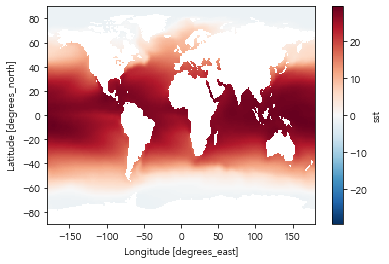

In [106]:
import xarray as xr

# Read the xarray dataset
ds = xr.open_dataset("../Data/HadISST_sst.nc")
ds['sst'] = ds['sst'].where(ds.sst != -1000, drop=True)
ds.mean(dim="time")['sst'].plot()

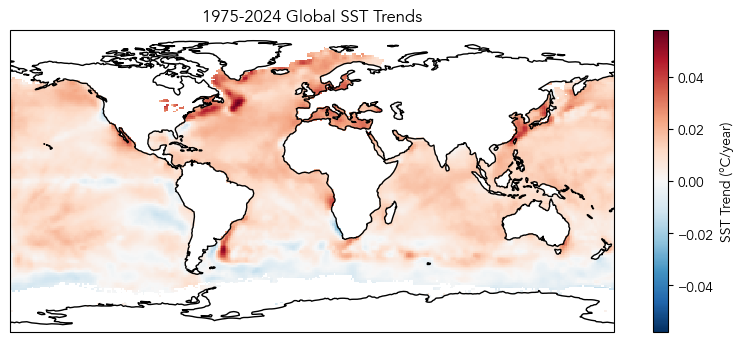

In [107]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import cartopy.crs as ccrs

# Calculate 10-year rolling average
ds_rolling = ds.rolling(time=120, center=False).mean()  # Assuming monthly data (120 months = 10 years)
ds_rolling = ds_rolling.sel(time=slice("1975-01-01", "2024-01-01"))

# Calculate linear trend for each grid point
def calculate_trend(x):
    if np.isnan(x).all():
        return np.nan
    else:
        return stats.linregress(range(len(x)), x).slope

# Apply the trend calculation to the entire dataset
trends = xr.apply_ufunc(
    calculate_trend,
    ds_rolling.sst.groupby('time.year').mean(),
    input_core_dims=[['year']],
    vectorize=True,
    output_dtypes=[float]
)

# Create a 10x10 plot
plt.figure(figsize=(10, 4), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the trends
im = trends.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', 
                 cbar_kwargs={'label': 'SST Trend (°C/year)'})

# Add coastlines and gridlines
ax.coastlines()

# Add title
plt.title('1975-2024 Global SST Trends')

# Set the font to Avenir
plt.rcParams['font.family'] = 'Avenir'

# Save the plot
plt.savefig('../Figures/sst_trends_10year_rolling.png', bbox_inches='tight')
plt.show()

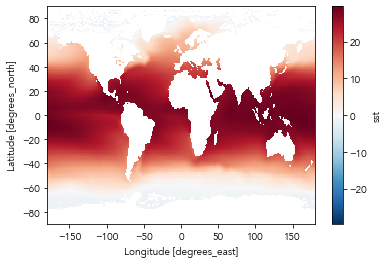

In [108]:
ds_rolling.sel(time=slice("1975-01-01", "2024-01-01")).mean(dim='time')['sst'].plot()

In [109]:
test = xr.open_dataset('../Data/seaice_conc_monthly_nh_197811_202312_v04r00.nc')
test

<xarray.Dataset>
Dimensions:                                 (tdim: 542, y: 448, x: 304)
Coordinates:
    time                                    (tdim) datetime64[ns] ...
    xgrid                                   (x) float32 ...
    ygrid                                   (y) float32 ...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc_monthly                 (tdim, y, x) float32 ...
    melt_onset_day_cdr_seaice_conc_monthly  (tdim, y, x) float32 ...
    nsidc_bt_seaice_conc_monthly            (tdim, y, x) float32 ...
    nsidc_nt_seaice_conc_monthly            (tdim, y, x) float32 ...
    projection                              |S1 ...
    qa_of_cdr_seaice_conc_monthly           (tdim, y, x) float32 ...
    stdev_of_cdr_seaice_conc_monthly        (tdim, y, x) float32 ...
    latitude                                (y, x) float32 ...
    longitude                               (y, x) float32 ...
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc_monthly
    metadata_link:             https://nsidc.org/data/g02202/versions/4/
    spatial_resolution:        25km
    ...                        ...
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-22T15:54:55Z
    time_coverage_start:       1978-11-01T00:00:00Z
    time_coverage_end:         2023-12-31T23:59:59Z
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   The variable melt_onset_day_cdr_seaice_conc_mo...

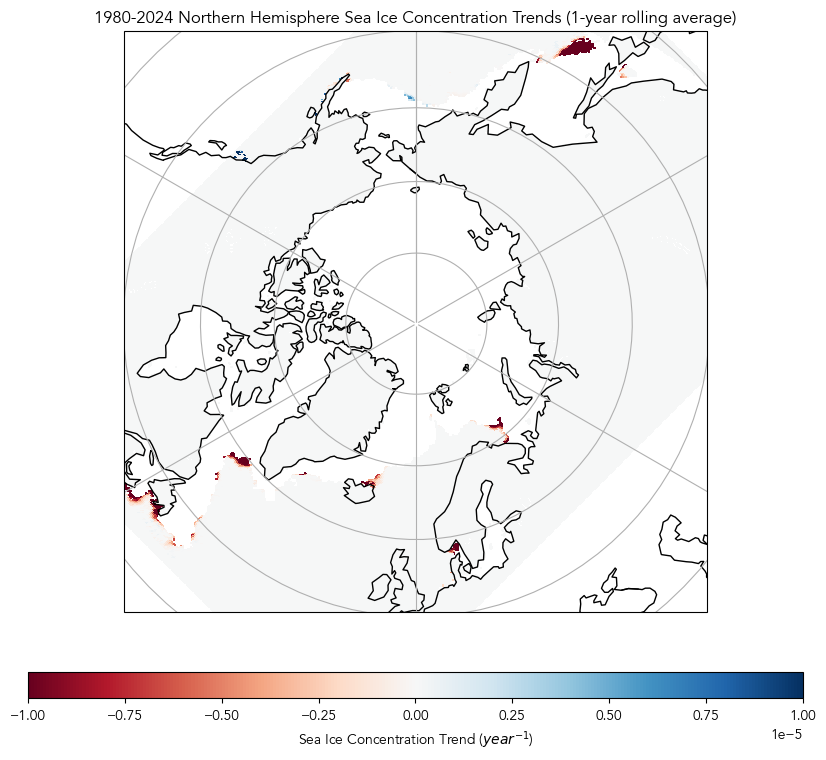

In [110]:
import xarray as xr
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# Load the dataset
ds = xr.open_dataset('../Data/seaice_conc_monthly_nh_197811_202312_v04r00.nc')

# Convert tdim to datetime if it's not already
if not np.issubdtype(ds.tdim.dtype, np.datetime64):
    ds['tdim'] = pd.to_datetime(ds['tdim']['time'].values)

# Calculate 1-year rolling average
ds_rolling = ds.rolling(tdim=12, center=False).mean()

# Now we can use datetime slicing
ds_rolling = ds_rolling.sel(tdim=slice("1980-01-01", "2024-01-01"))

# Define the trend calculation function
def calculate_trend(x):
    if np.isnan(x).all():
        return np.nan
    else:
        return stats.linregress(range(len(x)), x).slope

# Calculate trends
trends = xr.apply_ufunc(
    calculate_trend,
    ds_rolling.cdr_seaice_conc_monthly,
    input_core_dims=[['tdim']],
    vectorize=True,
    output_dtypes=[float]
)

# Create a plot
plt.figure(figsize=(10, 10), dpi=100)
ax = plt.axes(projection=ccrs.NorthPolarStereo())

# Plot the trends using latitude and longitude
im = ax.pcolormesh(ds.longitude, ds.latitude, trends, 
                   transform=ccrs.PlateCarree(),
                   cmap='RdBu', vmin=-1e-5, vmax=1e-5)

# Set the extent to focus on the Northern Hemisphere
ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label(r'Sea Ice Concentration Trend ($year^{-1}$)', fontsize=10)

# Add title
plt.title('1980-2024 Northern Hemisphere Sea Ice Concentration Trends (1-year rolling average)')

# Set the font to Avenir
plt.rcParams['font.family'] = 'Avenir'

# Save the plot
plt.savefig('../Figures/seaice_trends_1year_rolling_NH.png', bbox_inches='tight')
plt.show()

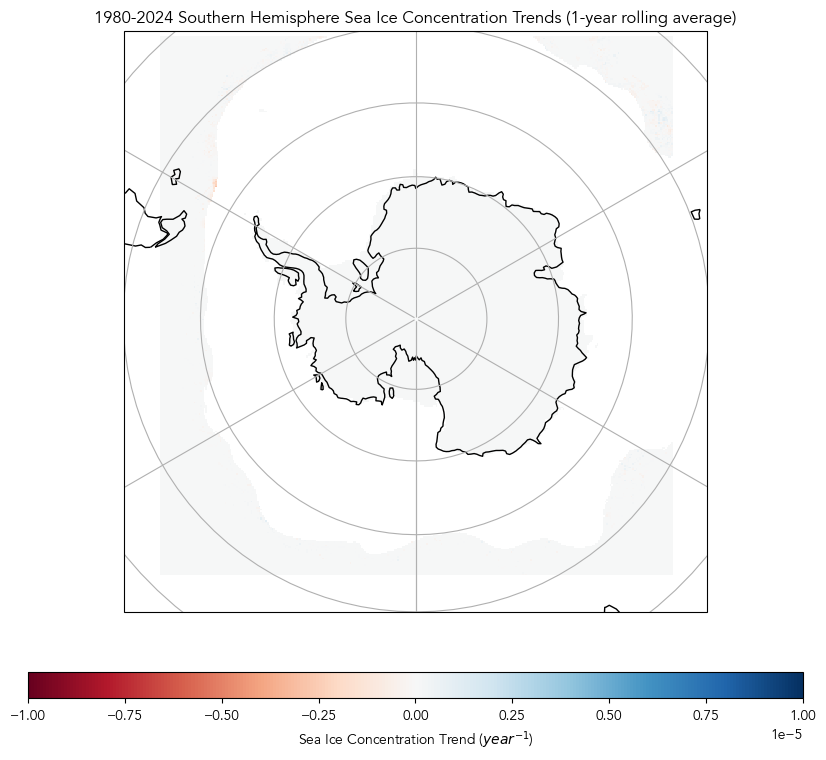

In [111]:
import xarray as xr
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# Load the dataset
ds = xr.open_dataset('../Data/seaice_conc_monthly_sh_197811_202312_v04r00.nc')

# Convert tdim to datetime if it's not already
if not np.issubdtype(ds.tdim.dtype, np.datetime64):
    ds['tdim'] = pd.to_datetime(ds['tdim']['time'].values)

# Calculate 1-year rolling average
ds_rolling = ds.rolling(tdim=12, center=False).mean()

# Now we can use datetime slicing
ds_rolling = ds_rolling.sel(tdim=slice("1980-01-01", "2024-01-01"))

# Define the trend calculation function
def calculate_trend(x):
    if np.isnan(x).all():
        return np.nan
    else:
        return stats.linregress(range(len(x)), x).slope

# Calculate trends
trends = xr.apply_ufunc(
    calculate_trend,
    ds_rolling.cdr_seaice_conc_monthly,
    input_core_dims=[['tdim']],
    vectorize=True,
    output_dtypes=[float]
)

# Create a plot
plt.figure(figsize=(10, 10), dpi=100)
ax = plt.axes(projection=ccrs.SouthPolarStereo())

# Plot the trends using latitude and longitude
im = ax.pcolormesh(ds.longitude, ds.latitude, trends, 
                   transform=ccrs.PlateCarree(),
                   cmap='RdBu', vmin=-1e-5, vmax=1e-5)

# Set the extent to focus on the Northern Hemisphere
ax.set_extent([-180, 180, -50, -90], crs=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label(r'Sea Ice Concentration Trend ($year^{-1}$)', fontsize=10)

# Add title
plt.title('1980-2024 Southern Hemisphere Sea Ice Concentration Trends (1-year rolling average)')

# Set the font to Avenir
plt.rcParams['font.family'] = 'Avenir'

# Save the plot
plt.savefig('../Figures/seaice_trends_1year_rolling_SH.png', bbox_inches='tight')
plt.show()

In [101]:
import xarray as xr
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# Load the dataset
ds = xr.open_dataset('/Users/pjs156/Downloads/woa23_7584_s00_01.nc',decode_times=False)
ds

<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 438.0
Dimensions without coordinates: nbounds
Data variables: (12/14)
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    s_an                (time, depth, lat, lon) float32 ...
    ...                  ...
    s_sd                (time, depth, lat, lon) float32 ...
    s_se                (time, depth, lat, lon) float32 ...
    s_oa                (time, depth, lat, lon) float32 ...
    s_gp                (time, depth, lat, lon) float64 ...
    s_sdo               (time, depth, lat, lon) float32 ...
    s_sea               (time, depth, lat, lon) float32 ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2023 : sea_water_pract...
    summary:                         Climatological mean salinity for the glo...
    references:                      Reagan, J.R., D. Seidov, Z. Wang, D. Duk...
    institution:                     NOAA National Centers for Environmental ...
    comment:                         Global Climatology as part of the World ...
    ...                              ...
    ncei_template_version:           NCEI_NetCDF_Grid_Template_v1.0
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   https://www.ncei.noaa.gov/products/world...
    date_created:                    2024-01-28 
    date_modified:                   2024-01-28

In [92]:
import xarray as xr
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# Load the dataset
ds = xr.open_dataset('../Data/woa23_decav_s00_04.nc')

# Convert tdim to datetime if it's not already
if not np.issubdtype(ds.tdim.dtype, np.datetime64):
    ds['tdim'] = pd.to_datetime(ds['tdim']['time'].values)

# Calculate 1-year rolling average
ds_rolling = ds.rolling(tdim=12, center=False).mean()

# Now we can use datetime slicing
ds_rolling = ds_rolling.sel(tdim=slice("1980-01-01", "2024-01-01"))

# Define the trend calculation function
def calculate_trend(x):
    if np.isnan(x).all():
        return np.nan
    else:
        return stats.linregress(range(len(x)), x).slope

# Calculate trends
trends = xr.apply_ufunc(
    calculate_trend,
    ds_rolling.cdr_seaice_conc_monthly,
    input_core_dims=[['tdim']],
    vectorize=True,
    output_dtypes=[float]
)

# Create a plot
plt.figure(figsize=(10, 10), dpi=100)
ax = plt.axes(projection=ccrs.SouthPolarStereo())

# Plot the trends using latitude and longitude
im = ax.pcolormesh(ds.longitude, ds.latitude, trends, 
                   transform=ccrs.PlateCarree(),
                   cmap='RdBu', vmin=-1e-5, vmax=1e-5)

# Set the extent to focus on the Northern Hemisphere
ax.set_extent([-180, 180, -50, -90], crs=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label(r'Sea Ice Concentration Trend ($year^{-1}$)', fontsize=10)

# Add title
plt.title('1980-2024 Southern Hemisphere Sea Ice Concentration Trends (1-year rolling average)')

# Save the plot
plt.savefig('seaice_trends_1year_rolling_SH.svg', bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/pjs156/Documents/Ode/ocean-central/Data/woa23_decav_s00_04.nc'